In [1]:
#we may need some code in the ../python directory and/or matplotlib styles
import sys
import os
sys.path.append('../python/')

#set up matplotlib
os.environ['MPLCONFIGDIR'] = '../mplstyles'
print(os.environ['MPLCONFIGDIR'])
import matplotlib as mpl
from matplotlib import pyplot as plt
#got smarter about the mpl config: see mplstyles/ directory
plt.style.use('standard')
print(mpl.__version__) 
print(mpl.get_configdir())


#fonts
# Set the font dictionaries (for plot title and axis titles)
title_font = {'fontname':'Arial', 'size':'16', 'color':'black', 'weight':'normal',
              'verticalalignment':'bottom'} # Bottom vertical alignment for more space
axis_font = {'fontname':'Arial', 'size':'32'}
legend_font = {'fontname':'Arial', 'size':'22'}

#fonts global settings
mpl.rc('font',family=legend_font['fontname'])


#set up numpy
import numpy as np

../mplstyles
3.0.3
/home/phys/villaa/analysis/misc/nrFano_Constraint/mplstyles


# Comparing Expected Yield Widths

It was mentioned at the end of the `ms_correction.ipynb` notebook that the yield widths did not seem to match between our simulated data and what Edw. predicted for the same resolutions used in the simulation, but with zero effective Fano factor. 

We want to explore that here because our modeling of the bands should be correct in both calculation and simulation before we can claim that the yield width discrepancy is likely to be due to an excess Fano factor. 

When we understand the modeling, then we can combine with results from the `ms_correction.ipynb` notebook to argue that neither our modeling uncertainty nore the inclusion of multiple-scatters can change the conclusion that the NR yield band is wider than expected. 

First we create some NR-scattering and ER-scattering data so we can model the yield widths with simulation. 

In [2]:
#read from the file to get NRs
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import h5py
#f = h5py.File("/data/chocula/villaa/k100Sim_Data/252Cf/k100_252Cf_shield_Edw_NRs.h5","r")
f = h5py.File("data/k100_252Cf_shield_Edw_NRs.h5","r") #use local data for continuous integration.


for i in f['nr_Fano']:
    print(i)

nr_energies
nr_hits


In [3]:
print(np.shape(f['nr_Fano/nr_energies']))
print(np.shape(f['nr_Fano/nr_hits']))

#get the data variables
nr_energies = np.asarray(f['nr_Fano/nr_energies'])
nr_hits = np.asarray(f['nr_Fano/nr_hits'])

nrsum = np.sum(nr_energies*1000,1)
print(np.shape(nr_energies))
print(np.shape(nr_hits))

(106173, 21)
(106173,)
(106173, 21)
(106173,)


In [4]:
#use the same generic shape to get the ER data but modify the number of events
Ner = 300000

er_energies = np.zeros((Ner,np.shape(nr_energies)[1]))
er_hits = np.ones((Ner,))

HighER=300
er_energies[:,0] = np.random.uniform(0,HighER,Ner)

print(np.shape(er_energies))
print(np.shape(er_hits))

print(er_energies[0:10,0])

(300000, 21)
(300000,)
[218.21760461 138.58928282 279.54075843 105.33933239 129.06874978
 293.72944303  79.62956402  44.31567877  46.7396681   12.25635759]


Recall the procedure for simulating data in the yield plane given true recoil data (that we've generated above).

The basic procedure is:

1. calculate the average electron-equivalent energy for every individual hit (scatter) in every individual event
2. calculate the average number of e/h pairs for each hit using the electron-equivalent energy
3. fluctuate the number of e/h pairs based on the variance in the number $\sigma_N = \sqrt{F\bar{N}}$
4. calculate the heat energy for each hit using the number of e/h pairs calculated above (recoil energy plus luke)
5. calculate the ionization energy for each hit using $\epsilon N$ 
6. sum the electron-equivalent energy over all hits in an event to get $E_I$, the total ionization energy
7. sum the heat energy over all hits in an event to get $E_H$, the total heat energy
8. add a random amount distributed like $N(0,\sigma_I(E_I))$ to the ionization energy
9. add a random amount distributed like $N(0,\sigma_H(E_H))$ to the total phonon energy
10. calculate the measured recoil energy for each event as $\tilde{E}_r = (1+(V/\epsilon))E_H - (V/\epsilon)E_I$
11. calculate the ionization yield for each event like $Q = E_I/\tilde{E}_r$

In [5]:
#constants
V=4.0 #volts
eps = 3.0/1000 #keV per pair, I usually use 3.3 for the numerator, but Edw. uses 3.
FWHM_to_SIG = 1 / (2*np.sqrt(2*np.log(2)))

#yield models
a=0.16
b=0.18
Qbar = lambda Er: a*Er**b

In [6]:
#start getting the resolutions
import EdwRes as er

#heatRes_GGA3 = er.get_heatRes_func(0.4, 2.7,aH*FWHM_to_SIG)
heatRes_GGA3 = er.get_heatRes_func(0.4, 2.7)

sigI_GGA3 = er.get_ionRes_func(1.3, 1.5, 3.1)

sigh_GGA3v = np.vectorize(heatRes_GGA3)
sigi_GGA3v = np.vectorize(sigI_GGA3)

In [7]:
#include a nominal Fano factor
F=0.0 #for NRs the factor is probably much higher than this

Enr = nr_energies*1000 #initial energies are in MeV
Enr_ss = nr_energies[nr_hits==1]*1000 #initial energies are in MeV
Eer_ss = er_energies[er_hits==1] #initial energies are in keV

#step 1
EIhit_av = Qbar(Enr)*Enr
EIhit_av_ss = Qbar(Enr_ss)*Enr_ss
EIerhit_av_ss = Eer_ss

#step 2
Nhit_av = EIhit_av/eps
Nhit_av_ss = EIhit_av_ss/eps
Nerhit_av_ss = EIerhit_av_ss/eps

#step 3
Nhit = np.around(np.random.normal(Nhit_av,np.sqrt(F*Nhit_av))).astype(np.float)
Nhit_ss = np.around(np.random.normal(Nhit_av_ss,np.sqrt(F*Nhit_av_ss))).astype(np.float)
Nerhit_ss = np.around(np.random.normal(Nerhit_av_ss,np.sqrt(F*Nerhit_av_ss))).astype(np.float)

#step 4
EHhit = (Enr + Nhit*V/1000.0)/(1+(V/(1000*eps)))
EHhit_ss = (Enr_ss + Nhit_ss*V/1000.0)/(1+(V/(1000*eps)))
EHerhit_ss = (Eer_ss + Nerhit_ss*V/1000.0)/(1+(V/(1000*eps)))

#step 5
EIhit = eps*Nhit
EIhit_ss = eps*Nhit_ss
EIerhit_ss = eps*Nerhit_ss

#step 6
EI = np.sum(EIhit,1)
EI_ss = np.sum(EIhit_ss,1)
EIer_ss = np.sum(EIerhit_ss,1)

#step 7
EH = np.sum(EHhit,1)
EH_ss = np.sum(EHhit_ss,1)
EHer_ss = np.sum(EHerhit_ss,1)

#step 8
EI = EI + np.random.normal(0.0,sigi_GGA3v(EI))
EI_ss = EI_ss + np.random.normal(0.0,sigi_GGA3v(EI_ss))
EIer_ss = EIer_ss + np.random.normal(0.0,sigi_GGA3v(EIer_ss))

#step 9
EH = EH + np.random.normal(0.0,sigh_GGA3v(EH))
EH_ss = EH_ss + np.random.normal(0.0,sigh_GGA3v(EH_ss))
EHer_ss = EHer_ss + np.random.normal(0.0,sigh_GGA3v(EHer_ss))

#step 10
Ernr = (1+(V/(1000*eps)))*EH - (V/(1000*eps))*EI
Ernr_ss = (1+(V/(1000*eps)))*EH_ss - (V/(1000*eps))*EI_ss
Erer_ss = (1+(V/(1000*eps)))*EHer_ss - (V/(1000*eps))*EIer_ss

#step 11
Q = EI/Ernr
Q_ss = EI_ss/Ernr_ss
Qer_ss = EIer_ss/Erer_ss

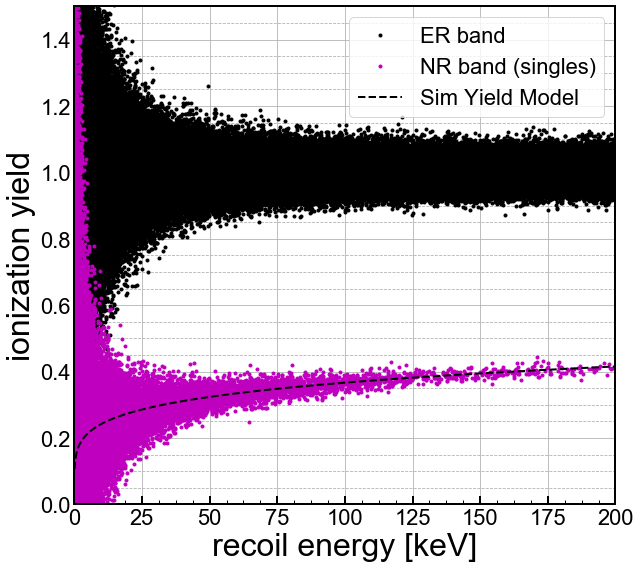

In [8]:
#set up a 1d plot
fig,axes = plt.subplots(1,1,figsize=(9.0,8.0),sharex=True)
ax1 = axes


Ermax=200
X = np.arange(0.1,Ermax,0.1)
#ax1.plot(Erer,Yer,'o',color='k', label='ER band',linewidth=2,markersize=3)
ax1.plot(Erer_ss,Qer_ss,'o',color='k', label='ER band',linewidth=2,markersize=3)
ax1.plot(Ernr_ss,Q_ss,'o',color='m', label='NR band (singles)',linewidth=2,markersize=3)
ax1.plot(X,Qbar(X),'k--',label='Sim Yield Model')

#ax1.plot(X,ynr_muv(X),'r--',label='NR mu')
#ax1.plot(X,ynr_muv(X)+3*ynr_sigv(X),'r-',label='NR 3$\\sigma$')
#ax1.plot(X,ynr_muv(X)-3*ynr_sigv(X),'r-',label=None)

#ax1.plot(X,yer_muv(X),color='orange',linestyle='--',label='ER mu')
#ax1.plot(X,yer_muv(X)+3*yer_sigv(X),color='orange',linestyle='-',label='ER 3$\\sigma$')
#ax1.plot(X,yer_muv(X)-3*yer_sigv(X),color='orange',linestyle='-',label=None)



#ax1.axvline(t(t_test[idx]), color='k', linestyle='-', lw=2, alpha=0.8,label=None)


ymin = 0
ymax = 1.5



ax1.set_yscale('linear')
#ax1.set_yscale('linear')
ax1.set_xlim(0, Ermax) 
ax1.set_ylim(ymin,ymax)
ax1.set_xlabel(r'recoil energy [keV]',**axis_font)
ax1.set_ylabel('ionization yield',**axis_font)
ax1.grid(True)
ax1.yaxis.grid(True,which='minor',linestyle='--')
ax1.legend(loc=1,prop={'size':22})
#ax1.legend(bbox_to_anchor=(1.04,1),borderaxespad=0,prop={'size':22})

for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(2)

plt.tight_layout()
#plt.savefig('figures/figure.png')
plt.show()

In [9]:
import histogram_yield as hy


erbins = [0,20,40,60,80,100,120,140,160,180,200]
bindf_er = hy.QEr_Ebin(Qer_ss, Erer_ss, erbins)
#nrbins=[5, 10, 20, 30, 40, 50, 70,150]
nrbins=[0, 10, 20, 30, 40, 50, 60,70,80,90,100,110,120,130,140,150]
bindf_nr = hy.QEr_Ebin(Q_ss, Ernr_ss, nrbins)

energy
(0, 20]       19736
(20, 40]      19944
(40, 60]      20065
(60, 80]      20119
(80, 100]     19954
(100, 120]    19821
(120, 140]    20195
(140, 160]    19845
(160, 180]    19995
(180, 200]    20000
dtype: int64
energy
(0, 10]       29321
(10, 20]       3729
(20, 30]       1873
(30, 40]       1142
(40, 50]        735
(50, 60]        535
(60, 70]        421
(70, 80]        321
(80, 90]        224
(90, 100]       183
(100, 110]      141
(110, 120]      103
(120, 130]       70
(130, 140]       50
(140, 150]       42
dtype: int64


In [10]:
#import imp
#imp.reload(hy)
qbins_er=np.linspace(0.5,1.5,40)
qhistos_er,qerrs_er = hy.QEr_Qhist(bindf_er, qbins_er)
#print(qhistos_er)

qbins_nr=np.linspace(0.0,0.6,40)
qhistos_nr,qerrs_nr = hy.QEr_Qhist(bindf_nr, qbins_nr)
#print(qhistos_nr)

xcq_er = (qbins_er[:-1] + qbins_er[1:]) / 2
print(qhistos_er[:,1]/np.sum(qhistos_er[:,1]))

[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.50421179e-04 2.50701966e-04
 3.00842359e-04 7.52105897e-04 2.15603690e-03 4.31207381e-03
 8.12274368e-03 1.42398716e-02 2.88808664e-02 4.93882872e-02
 7.84195748e-02 1.06548335e-01 1.33624148e-01 1.37384677e-01
 1.27657441e-01 1.08904934e-01 7.47091857e-02 5.44023265e-02
 3.30926594e-02 1.89029282e-02 8.57400722e-03 5.06417970e-03
 2.15603690e-03 9.02527076e-04 6.01684717e-04 3.00842359e-04
 1.00280786e-04 5.01403931e-05 5.01403931e-05 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00]


In [11]:
#try fitting.
qamps_er,qampserrs_er,qmus_er,qmuerrs_er,qsigs_er,qsigerrs_er = hy.QEr_Qfit(qhistos_er,qerrs_er, qbins_er)
qamps_nr,qampserrs_nr,qmus_nr,qmuerrs_nr,qsigs_nr,qsigerrs_nr = hy.QEr_Qfit(qhistos_nr,qerrs_nr, qbins_nr,0.1,0.3,0.1)

fitting 0
lmfit results
[[Variables]]
    amp:   0.05244280 +/- 0.00172816 (3.30%) (init = 0.1)
    mean:  0.99791720 +/- 0.00501060 (0.50%) (init = 1)
    sig:   0.19254126 +/- 0.00443447 (2.30%) (init = 0.1)
[[Correlations]] (unreported correlations are < 0.100)
    C(amp, sig) = -0.649
None
fitting 1
lmfit results
[[Variables]]
    amp:   0.13389876 +/- 0.00182884 (1.37%) (init = 0.1)
    mean:  1.00180238 +/- 8.3242e-04 (0.08%) (init = 1)
    sig:   0.07601490 +/- 6.2479e-04 (0.82%) (init = 0.1)
[[Correlations]] (unreported correlations are < 0.100)
    C(amp, sig) = -0.600
None
fitting 2
lmfit results
[[Variables]]
    amp:   0.20121749 +/- 0.00155136 (0.77%) (init = 0.1)
    mean:  1.00243206 +/- 3.1700e-04 (0.03%) (init = 1)
    sig:   0.05075906 +/- 2.3067e-04 (0.45%) (init = 0.1)
[[Correlations]] (unreported correlations are < 0.100)
    C(amp, sig) = -0.588
None
fitting 3
lmfit results
[[Variables]]
    amp:   0.24427905 +/- 0.00233586 (0.96%) (init = 0.1)
    mean:  1.001345

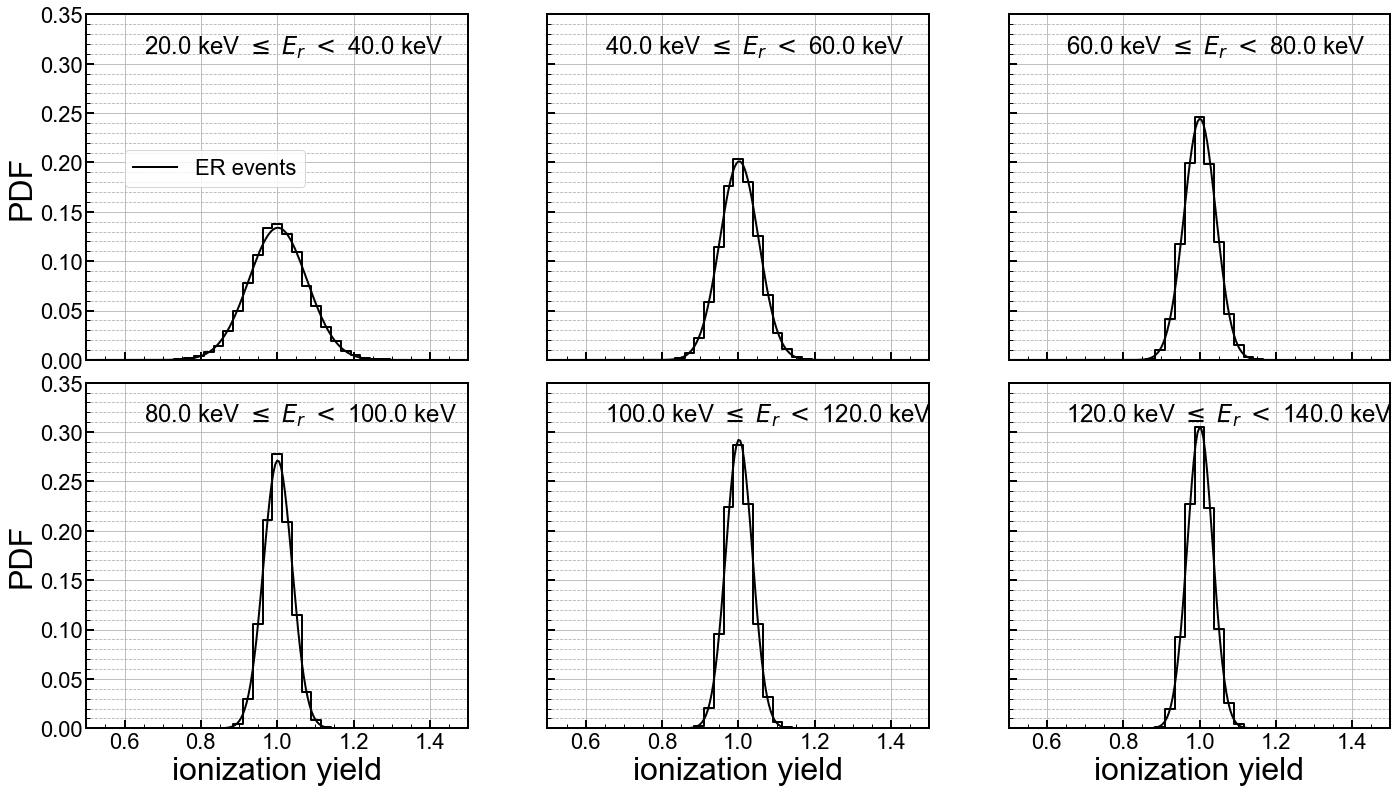

In [12]:
fig,axs = plt.subplots(2,3,figsize=(20.0,11.0),sharex=True,sharey=True)



X = np.arange(0.5,1.5,0.005)
func = lambda x,a,b,c: a*np.exp(-(x-b)**2/(2*c**2))
funcv = np.vectorize(func)

for i,ax in enumerate(np.ndarray.flatten(axs)):
    #ax.set_title('markevery=%s' % str(case))
    #ax.plot(x, y, 'o', ls='-', ms=4, markevery=case)
    ax.text(0.65,0.31,"{:2.1f} keV $\leq$ $E_r$ $<$ {:2.1f} keV".format(erbins[i+1],erbins[i+2]),fontsize=24)
    idx=i+1
    ax.plot(X,funcv(X,qamps_er[i+1],qmus_er[i+1],qsigs_er[i+1]),color='k',linestyle="-",linewidth=2)
    #ax.plot(X,funcv(X,qamps_ss[i+1],qmus_ss[i+1],qsigs_ss[i+1]),color='m',linestyle="-",linewidth=2)
    #ax.step(xcq_er,qhistos[:,idx]/np.sum(qhistos[:,idx]), where='mid',color='b', linestyle='-', \
    #        label='all scatters', linewidth=2)
    ax.step(xcq_er,qhistos_er[:,idx]/np.sum(qhistos_er[:,idx]), where='mid',color='k', linestyle='-', \
            label='ER events', linewidth=2)
    ax.set_yscale('linear')
    #ax1.set_yscale('linear')
    ax.set_xlim(0.5, 1.5) 
    ax.set_ylim(0,0.35)
    if(i>2):
      ax.set_xlabel(r'ionization yield',**axis_font)
    if((i==0)|(i==3)):
      ax.set_ylabel('PDF',**axis_font)
    ax.grid(True)
    ax.yaxis.grid(True,which='minor',linestyle='--')
    if(idx==1):
      ax.legend(loc=(0.1,0.5),prop={'size':22})
    for axis in ['top','bottom','left','right']:
      ax.spines[axis].set_linewidth(2)
 
plt.tight_layout() 
plt.show()

In [13]:
#make functions for analytical bands
#modify heat resolution by adding aH

#figure out what the default aH is for this setting
FWHM0 = 0.4
FWHM122 = 2.7
sig0 = FWHM0 * FWHM_to_SIG
sig122 = FWHM122 * FWHM_to_SIG  
aH = np.sqrt((sig122**2 - sig0**2)/122**2)
print('default aH in FWHM: {}'.format(aH/FWHM_to_SIG))

aH=(aH/FWHM_to_SIG) #use default
#aH=0.02 #use custom
heatRes_GGA3_new = er.get_heatRes_func(0.4, 2.7,aH*FWHM_to_SIG)
#heatRes_GGA3_new = er.get_heatRes_func(0.4, 2.7)
sigh_GGA3v_new = np.vectorize(heatRes_GGA3_new)
#sigh_GGA3v = np.vectorize(heatRes_GGA3)
#sigi_GGA3v = np.vectorize(sigI_GGA3)

#new resolution functions 
Ehee = lambda Er: ((1+(V/(1000*eps))*Qbar(Er))*Er)/(1+(V/(1000*eps)))
EIee = lambda Er: Qbar(Er)*Er


#accounting for energy-scale difference
sigH_NR = lambda Er: sigh_GGA3v_new(Ehee(Er))
sigI_NR = lambda Er: sigi_GGA3v(EIee(Er))

#not accounting for energy scale difference
#sigH_NR = lambda Er: sigh_GGA3v_new(Er)
#sigI_NR = lambda Er: sigi_GGA3v(Er)

sigH_ER = sigh_GGA3v_new
sigI_ER = sigi_GGA3v



sigQnr = lambda Etr: (1/Etr)*np.sqrt((1+(V/(1000*eps))*Qbar(Etr))**2*sigI_NR(Etr)**2 + (1+(V/(1000*eps)))**2 \
                                     *Qbar(Etr)**2*sigH_NR(Etr)**2)

sigQer = lambda Etr: (1/Etr)*np.sqrt((1+(V/(1000*eps)))**2*sigI_ER(Etr)**2 + (1+(V/(1000*eps)))**2 \
                                     *sigH_ER(Etr)**2)


print(sigQnr(150))
print(sigH_NR(10))
print(sigI_NR(10))
print(sigQer(150))
print(sigH_ER(10))
print(sigI_ER(10))
sigQnrv = np.vectorize(sigQnr)
sigQerv = np.vectorize(sigQer)

default aH in FWHM: 0.02188693429970277
0.011433326942367058
0.17785032317118576
0.8431667681790007
0.03198864660913636
0.19363037139445397
0.8469930156920004


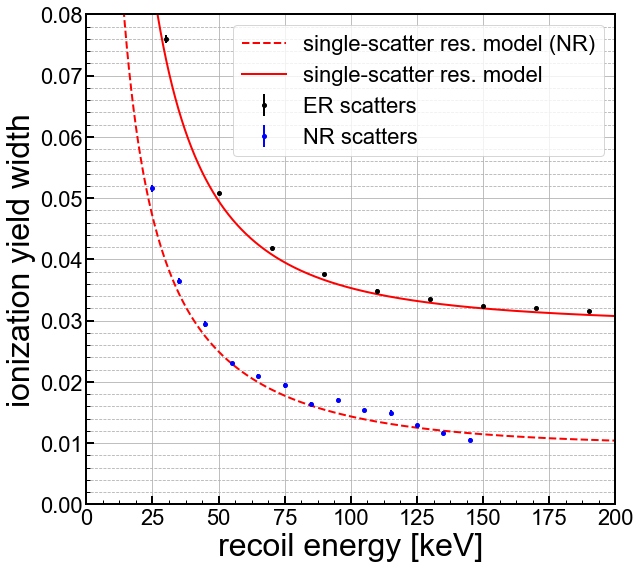

In [14]:
#set up a 1d plot
fig,axes = plt.subplots(1,1,figsize=(9.0,8.0),sharex=True)
ax1 = axes


#bins = np.asarray(erbins)
erbins=np.asarray(erbins)
nrbins=np.asarray(nrbins)
xE = (erbins[:-1] + erbins[1:]) / 2
xEnr = (nrbins[:-1] + nrbins[1:]) / 2


X=np.arange(0.1,200,0.1)


ax1.plot(X,sigQnrv(X),color='r',linestyle="--",linewidth=2,label='single-scatter res. model (NR)'.format(aH))
ax1.plot(X,sigQerv(X),color='r',linestyle="-",linewidth=2,\
         label='single-scatter res. model'.format(0.02))
ax1.errorbar(xE,np.sqrt(qsigs_er**2), yerr=qsigerrs_er,color='k', marker='o', \
         markersize=4,linestyle='none',label='ER scatters', linewidth=2)
ax1.errorbar(xEnr,np.sqrt(qsigs_nr**2), yerr=qsigerrs_nr,color='b', marker='o', \
         markersize=4,linestyle='none',label='NR scatters', linewidth=2)
#ax1.errorbar(xE,qsigs_ss, yerr=qsigerrs_ss,color='m', marker='o', \
#         markersize=4,linestyle='none',label='single scatters', linewidth=2)



ymin = 0.0
ymax = 0.08



ax1.set_yscale('linear')
#ax1.set_yscale('log')
ax1.set_xlim(0, 200) 
ax1.set_ylim(ymin,ymax)
ax1.set_xlabel(r'recoil energy [keV]',**axis_font)
ax1.set_ylabel('ionization yield width',**axis_font)
ax1.grid(True)
ax1.yaxis.grid(True,which='minor',linestyle='--')
ax1.legend(loc=1,prop={'size':22})
#ax1.legend(bbox_to_anchor=(1.04,1),borderaxespad=0,prop={'size':22})

for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(2)

plt.tight_layout()
#plt.savefig('figures/figure.png')
plt.show()

In [15]:
import scipy

scipy.stats.poisson.interval(0.68, [0,10, 20, 30,1**2])

(array([ 0.,  7., 16., 25.,  0.]), array([ 0., 13., 24., 35.,  2.]))

In [16]:
N=1
upper = N + 2. * np.sqrt(N + 1) + 4. / 3.
lower = N * (1. - 1. / (9. * N) - 2. / (3. * np.sqrt(N))) ** 3.

print(upper)
print(lower)

5.161760458079524
0.010973936899862823


In [17]:
import gammapy.stats as gstats
from scipy import stats


Nbknd=0.0
x_bins = np.arange(0, 50)
mu_bins = np.linspace(0, 25, np.int(np.round(25 / 0.005 + 1,0)), endpoint=True)
matrix = [stats.poisson(mu + Nbknd).pmf(x_bins) for mu in mu_bins]


acceptance_intervals = gstats.fc_construct_acceptance_intervals_pdfs(matrix, 0.6827)
LowerLimitNum, UpperLimitNum, _ = gstats.fc_get_limits(mu_bins, x_bins, acceptance_intervals)

#print(matrix)
print(mu_bins)
#print(LowerLimitNum)
#print(UpperLimitNum)
N=14
print(gstats.fc_find_limit(N, UpperLimitNum, mu_bins))
print(gstats.fc_find_limit(N, LowerLimitNum, mu_bins))

[0.0000e+00 5.0000e-03 1.0000e-02 ... 2.4990e+01 2.4995e+01 2.5000e+01]
18.315
10.3


In [18]:
print(acceptance_intervals)

[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 1. 1.]
 [0. 0. 0. ... 1. 1. 1.]
 [0. 0. 0. ... 1. 1. 1.]]
